In [1]:
from utils.flax_utils import restore_agent
import glob, tqdm, wandb, os, json, random, time, jax
from absl import app, flags
from ml_collections import config_flags
from log_utils import setup_wandb, get_exp_name, get_flag_dict, CsvLogger

from envs.env_utils import make_env_and_datasets
from envs.ogbench_utils import make_ogbench_env_and_datasets
from envs.robomimic_utils import is_robomimic_env

from utils.flax_utils import save_agent
from utils.datasets import Dataset, ReplayBuffer

from evaluation import evaluate
from agents import agents
import numpy as np

ROBOMIMIC WARNING(
    No private macro file found!
    It is recommended to use a private macro file
    To setup, run: python /home/v-hokyunim/miniconda3/envs/debs/lib/python3.10/site-packages/robomimic/scripts/setup_macros.py
)


In [2]:
# handle dataset
dataset_proportion = 1.0
def process_train_dataset(ds):
    """
    Process the train dataset to 
        - handle dataset proportion
        - handle sparse reward
        - convert to action chunked dataset
    """

    ds = Dataset.create(**ds)
    if dataset_proportion < 1.0:
        new_size = int(len(ds['masks']) * dataset_proportion)
        ds = Dataset.create(
            **{k: v[:new_size] for k, v in ds.items()}
        )

    return ds

In [3]:
ds_name = 'cube-single-play-singletask-task1-v0'
env, eval_env, train_dataset, val_dataset = make_env_and_datasets(ds_name)

train_dataset = process_train_dataset(train_dataset)
example_batch = train_dataset.sample(())

/home/v-hokyunim/miniconda3/envs/debs/lib/python3.10/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/v-hokyunim/miniconda3/envs/debs/lib/python3.10/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [4]:
FLAGS = flags.FLAGS

flags.DEFINE_string('run_group', 'Debug', 'Run group.')
flags.DEFINE_integer('seed', 0, 'Random seed.')
flags.DEFINE_string('env_name', 'cube-triple-play-singletask-task2-v0', 'Environment (dataset) name.')
flags.DEFINE_string('save_dir', 'exp/', 'Save directory.')

flags.DEFINE_integer('offline_steps', 1000000, 'Number of online steps.')
flags.DEFINE_integer('online_steps', 1000000, 'Number of online steps.')
flags.DEFINE_integer('buffer_size', 2000000, 'Replay buffer size.')
flags.DEFINE_integer('log_interval', 5000, 'Logging interval.')
flags.DEFINE_integer('eval_interval', 100000, 'Evaluation interval.')
flags.DEFINE_integer('save_interval', -1, 'Save interval.')
flags.DEFINE_integer('start_training', 5000, 'when does training start')

flags.DEFINE_integer('utd_ratio', 1, "update to data ratio")

flags.DEFINE_float('discount', 0.99, 'discount factor')

flags.DEFINE_integer('eval_episodes', 50, 'Number of evaluation episodes.')
flags.DEFINE_integer('video_episodes', 0, 'Number of video episodes for each task.')
flags.DEFINE_integer('video_frame_skip', 3, 'Frame skip for videos.')

config_flags.DEFINE_config_file('agent', 'agents/debs.py', lock_config=False)

flags.DEFINE_float('dataset_proportion', 1.0, "Proportion of the dataset to use")
flags.DEFINE_integer('dataset_replace_interval', 1000, 'Dataset replace interval, used for large datasets because of memory constraints')
flags.DEFINE_string('ogbench_dataset_dir', None, 'OGBench dataset directory')

flags.DEFINE_integer('horizon_length', 5, 'action chunking length.')
flags.DEFINE_bool('sparse', False, "make the task sparse reward")

flags.DEFINE_bool('save_all_online_states', False, "save all trajectories to npy")

In [5]:
import jax
import jax.numpy as jnp
from typing import Tuple

def calculate_mc_returns_with_mask(
    rewards: jnp.ndarray, 
    mask: jnp.ndarray, 
    gamma: float, 
    v_min: float = 0.0 # PyTorch 코드의 'self.v_min' 대체
) -> jnp.ndarray:
    """
    Calculates Monte Carlo (MC) returns (Reward-to-Go) using jax.lax.scan.

    Args:
        rewards (jnp.ndarray): Sequence of rewards (N).
        mask (jnp.ndarray): Mask indicating valid steps (1 for valid, 0 for terminal/invalid) (N).
        gamma (float): The discount factor.
        v_min (float): The value used to initialize/reset the return at the end of a trajectory.

    Returns:
        jnp.ndarray: The calculated MC return (Reward-to-Go) for each step (N).
    """
    
    n_steps = rewards.shape[0]

    # 1. 시퀀스 뒤집기 (Backward iteration을 forward scan으로 처리하기 위함)
    rewards_rev = jnp.flip(rewards)
    mask_rev = jnp.flip(mask)
    
    # 파이토치 코드의 논리에 맞게, 현재 마스크와 이전 스텝의 마스크를 준비합니다.
    # 이전 스텝의 마스크를 얻기 위해 mask_rev를 shift 합니다.
    # shift_mask_rev[t]는 PyTorch 코드의 mask[t-1]과 동일한 역할을 합니다.
    # scan을 위해 0으로 패딩 (맨 처음 스텝의 이전은 항상 0/무효 처리)
    shifted_mask_rev = jnp.concatenate([jnp.array([0]), mask_rev[:-1]])


    # 2. Scan 함수 정의
    # JAX scan은 (carry, x) -> (carry, y) 형태를 가집니다.
    # carry: current_return (running return)
    # x: (r_t, m_t, m_{t-1})
    
    def scan_fn(carry: float, x: Tuple[float, float, float]) -> Tuple[float, float]:
        """
        Calculates the running return G_t = r_t + gamma * G_{t+1}.
        Handles trajectory reset based on the mask.
        """
        current_return = carry
        r_t, m_t, m_t_minus_1 = x # t는 reversed된 인덱스

        # PyTorch Logic (translated to JAX):
        # --------------------------------------------------------------------------------
        
        # 1. m_t == 0 (현재가 Sub-trajectory의 끝/터미널)인 경우:
        #    a) (t != 0) and (mask[t-1] == 1): 이전이 valid했다면, r_t로 리턴을 리셋하고 시작
        #       -> if m_t_minus_1 == 1: current_return = r_t
        #    b) else: 리턴을 0으로 리셋
        #       -> else: current_return = 0
        
        reset_by_reward = jnp.where(m_t_minus_1 == 1, r_t, 0.0)
        
        # 2. m_t == 1 (현재가 Valid 스텝)인 경우:
        #    G_t = r_t + gamma * G_{t+1}
        #    -> G_t = r_t + gamma * current_return
        
        updated_return_valid = r_t + gamma * current_return
        
        # 3. 최종 업데이트: m_t에 따라 선택
        # m_t == 0 이면 reset_by_reward를, m_t == 1 이면 updated_return_valid를 선택
        new_return = jnp.where(m_t == 1, updated_return_valid, reset_by_reward)
        
        # --------------------------------------------------------------------------------
        
        # JAX scan의 출력은 (다음 carry, scan 결과)
        return new_return, new_return

    # Scan의 초기값은 G_{N} (마지막 스텝의 다음 리턴)에 해당하며, 
    # PyTorch 코드의 'current_return = self.v_min'에 대응
    initial_carry = v_min 
    
    # 3. Scan 실행
    # 입력 시퀀스: (rewards_rev, mask_rev, shifted_mask_rev)
    # _ : 최종 carry 값 (사용하지 않음)
    # mc_returns_rev: 각 스텝의 MC 리턴 값 (뒤집힌 상태)
    _, mc_returns_rev = jax.lax.scan(
        scan_fn,
        initial_carry,
        (rewards_rev, mask_rev, shifted_mask_rev)
    )

    # 4. 결과 다시 뒤집기 (원래 시퀀스 순서로 복구)
    mc_returns = jnp.flip(mc_returns_rev)
    
    return mc_returns

In [6]:
import json
import ml_collections

def load_config_from_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    # 딕셔너리를 ConfigDict로 변환 (점 표기법 사용 가능 및 Type safety)
    config = ml_collections.ConfigDict(data)
    return config

path = '/home/v-hokyunim/Offline/debs/exp/debs/debs/cube-single-play-singletask-task1-v0/sd00020251207_155932'
flag_config = load_config_from_json(f'{path}/flags.json')
config = flag_config.agent
config["horizon_length"] = flag_config.horizon_length

In [7]:
agent_class = agents['debs']
agent = agent_class.create(
    0,
    example_batch['observations'],
    example_batch['actions'],
    config,
)

In [8]:
agent = restore_agent(agent, path, 200000)

Restored from /home/v-hokyunim/Offline/debs/exp/debs/debs/cube-single-play-singletask-task1-v0/sd00020251207_155932/params_200000.pkl


In [9]:
mc_return = calculate_mc_returns_with_mask(
    train_dataset['rewards'], 
    train_dataset['masks'],
    gamma=0.99, 
    v_min=-100
)

In [10]:
import jax
import jax.numpy as jnp
from jax import lax

def create_discounted_n_step_windows(rewards, n_step=10, gamma=0.99):
    """
    rewards: (N,) shape의 1D array
    return: (N - n_step, n_step) shape의 discounted reward sequence
    """
    N = rewards.shape[0]
    
    # 1. Sliding Window 생성을 위한 시작 인덱스들
    # shape: (N - n_step,)
    start_indices = jnp.arange(N - n_step)
    
    # 2. 특정 인덱스에서 n_step만큼 잘라내는 함수 정의
    def get_window(start_idx):
        # dynamic_slice(operand, start_indices, slice_sizes)
        return lax.dynamic_slice(rewards, (start_idx,), (n_step,))
    
    # 3. vmap을 사용하여 모든 윈도우를 병렬로 추출
    # windows shape: (N - n_step, n_step)
    windows = jax.vmap(get_window)(start_indices)
    
    # 4. Gamma 적용 (Broadcasting)
    # discounts shape: (1, n_step) -> (1, 0.99, 0.99^2, ...)
    discounts = jnp.power(gamma, jnp.arange(n_step))
    
    # (N-10, 10) * (10,) 브로드캐스팅 곱셈
    discounted_windows = windows * discounts
    
    return discounted_windows.sum(axis=-1)

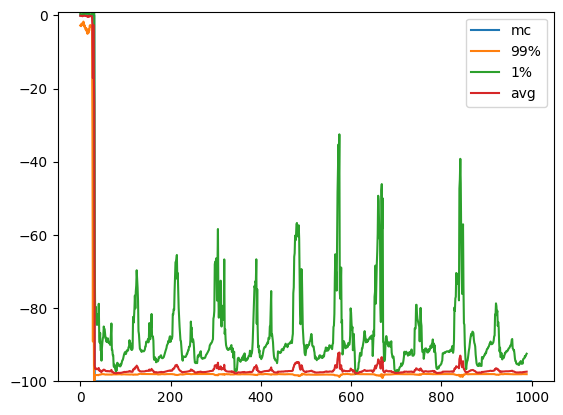

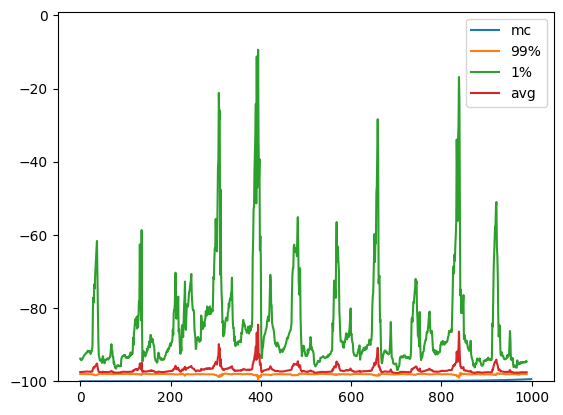

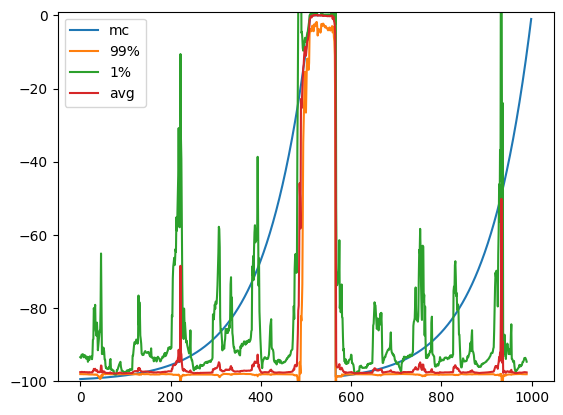

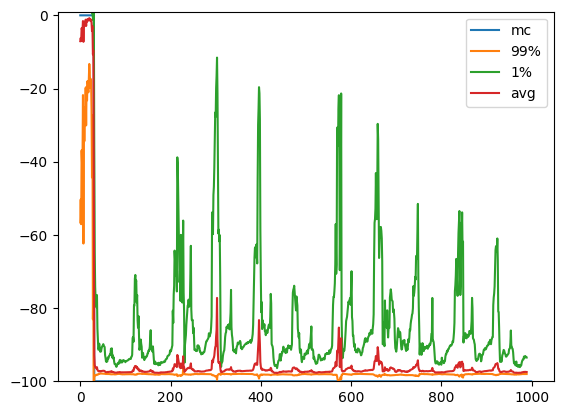

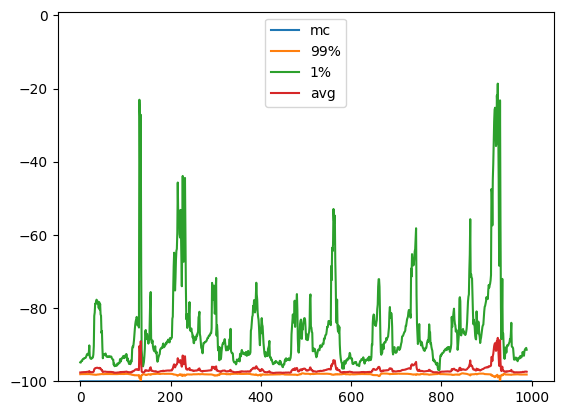

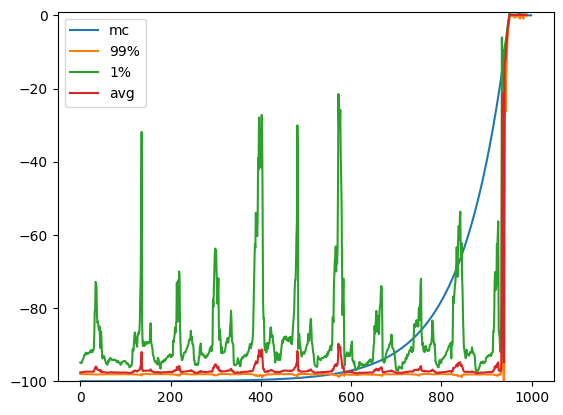

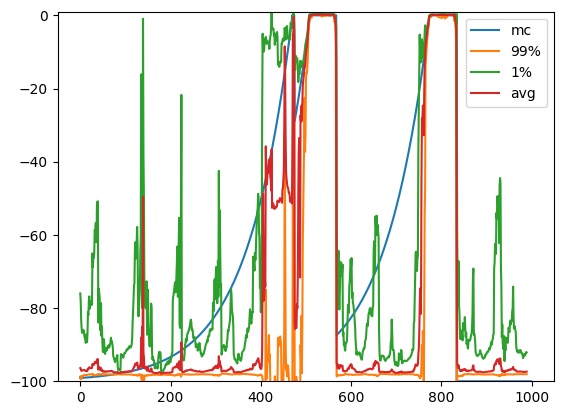

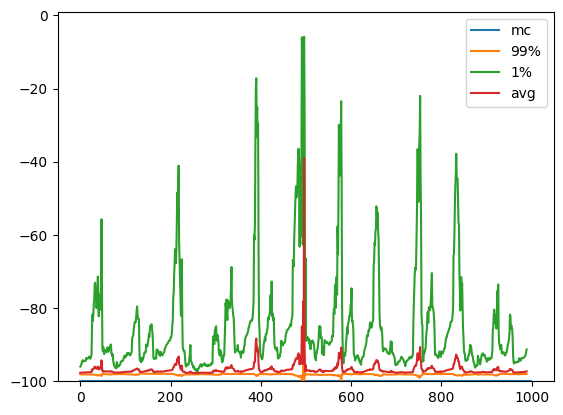

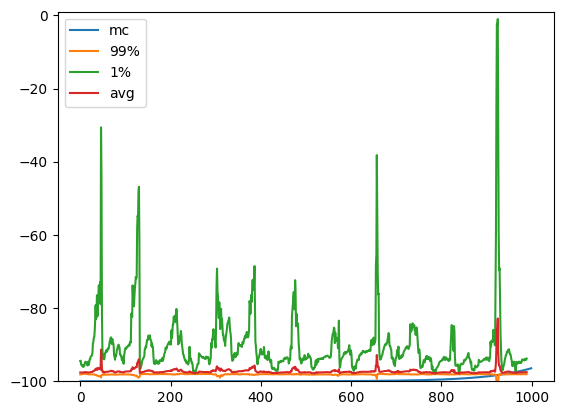

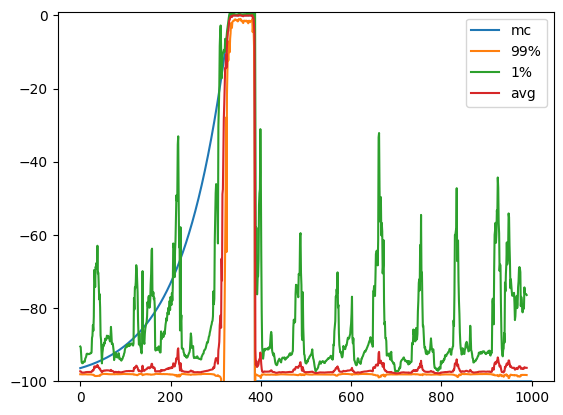

In [11]:
import matplotlib.pyplot as plt

length = 1000
for i in range(120, 130):
    obs_sample = train_dataset['observations'][i*length:(i)*length + length - 10]
    next_obs_sample = train_dataset['observations'][i*length + 10:i*length + length]
    rew_sample = train_dataset['rewards'][i*length:(i)*length + length - 10]
    mask = train_dataset['masks'][i*length:(i)*length + length - 10]
    current_zs = agent.network.select('critic')(obs_sample)
    next_zs = agent.network.select('critic')(next_obs_sample)
    n_step_returns = create_discounted_n_step_windows(train_dataset['rewards'][i*length:(i)*length + length], n_step=10, gamma=0.99)
    advantage = jnp.expand_dims(n_step_returns, axis=-1) + jnp.expand_dims((0.99 ** 10) * mask, axis=-1) * next_zs
    # advantage = jnp.expand_dims((0.99 ** 10) * mask, axis=-1) * next_zs
    # print(advantage.shape)
    np_zs = np.array(current_zs)

    # plt.plot(rew_sample*length)
    
    # plt.show()
    plt.plot(mc_return[i*length:(i+1)*length], label='mc')
    plt.ylim([-100, 1])
    # plt.plot(np_zs[:, 0])
    plt.plot(np_zs[:, 1], label='99%')
    # plt.plot(np_zs[:, -1])
    plt.plot(np_zs[:, -2], label='1%')
    plt.plot(np_zs.mean(axis=-1), label='avg')

    # plt.plot(advantage[:, -2], label='1%')
    # plt.plot(advantage[:].mean(axis=-1), label='adv avg')
    plt.legend()
    plt.show()

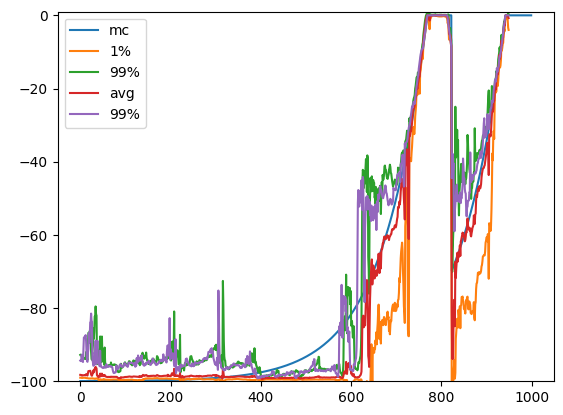

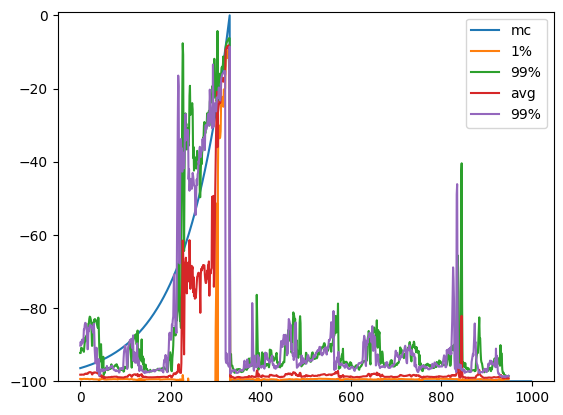

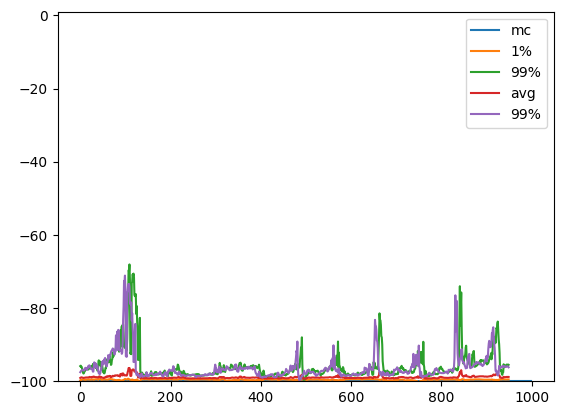

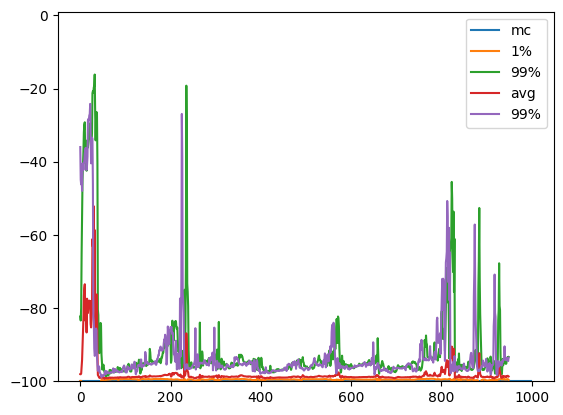

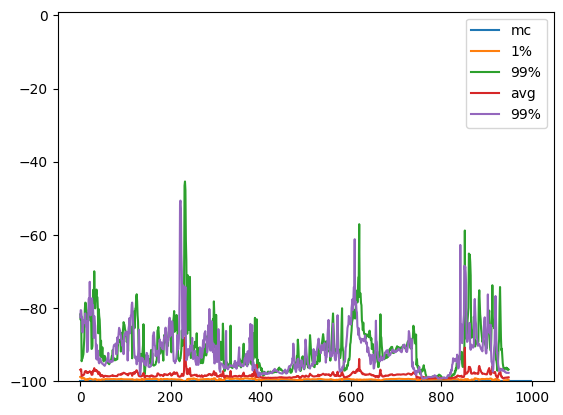

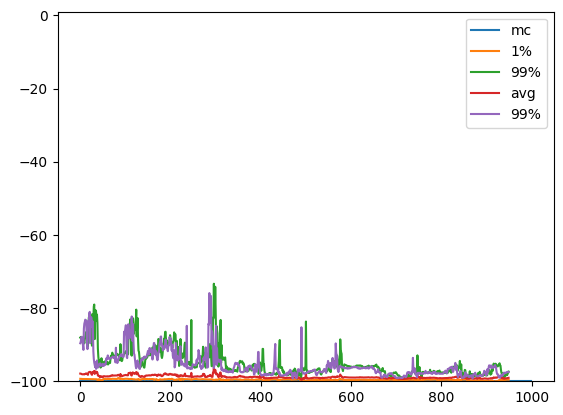

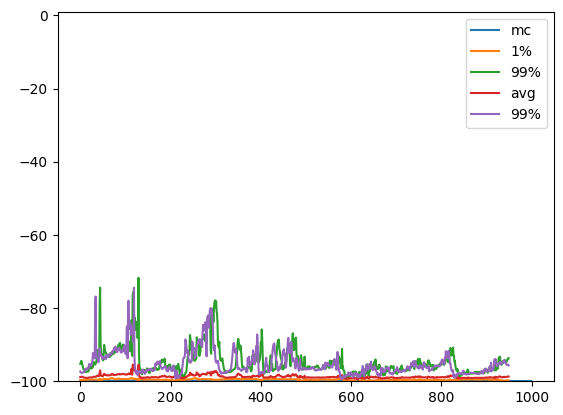

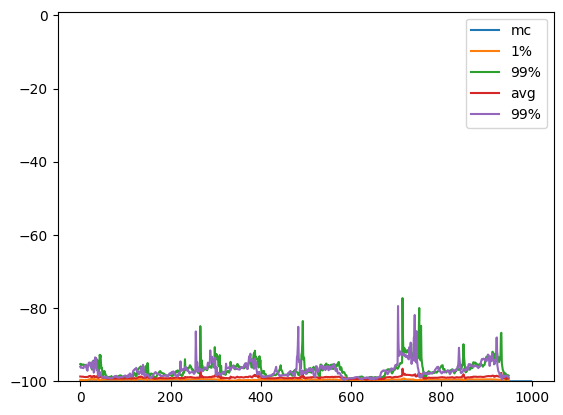

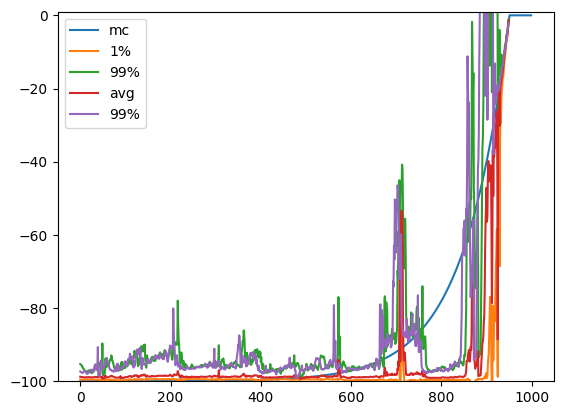

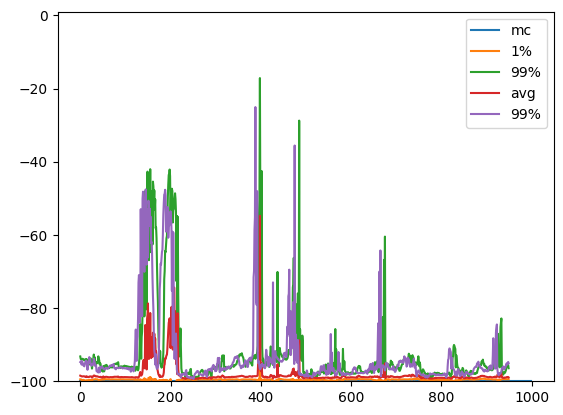

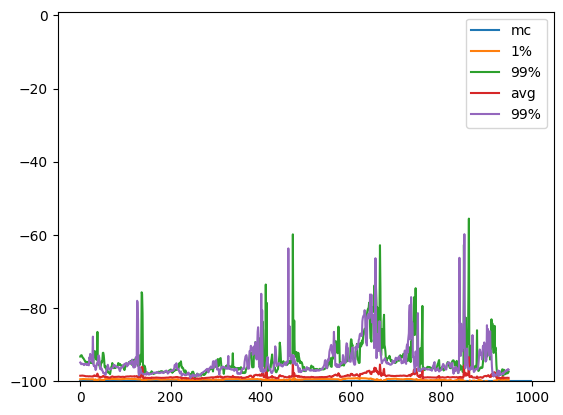

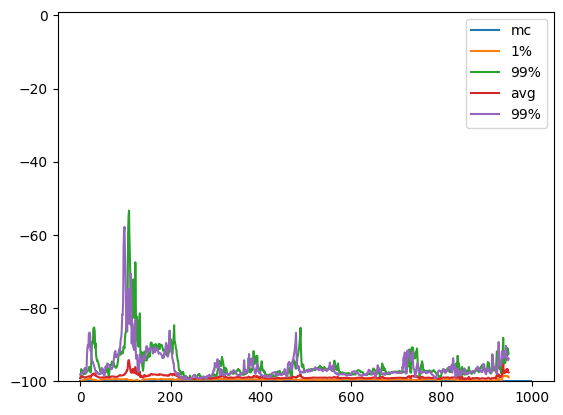

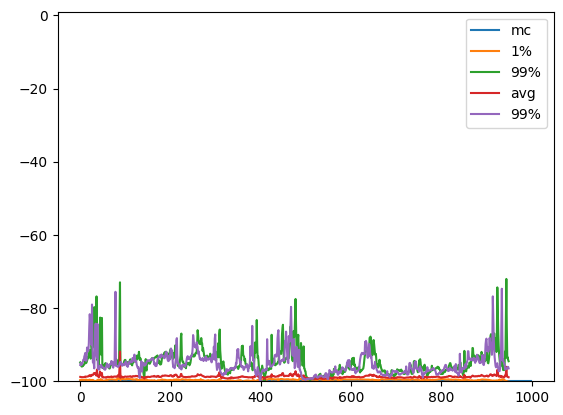

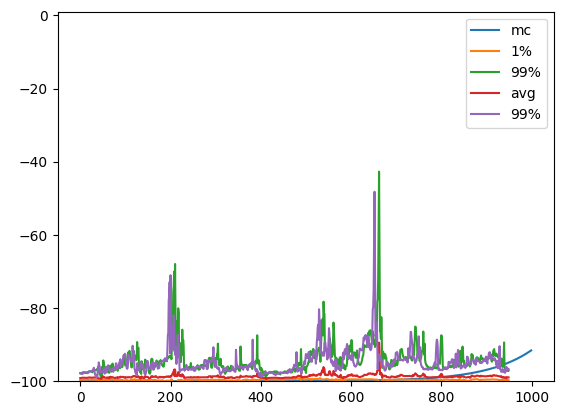

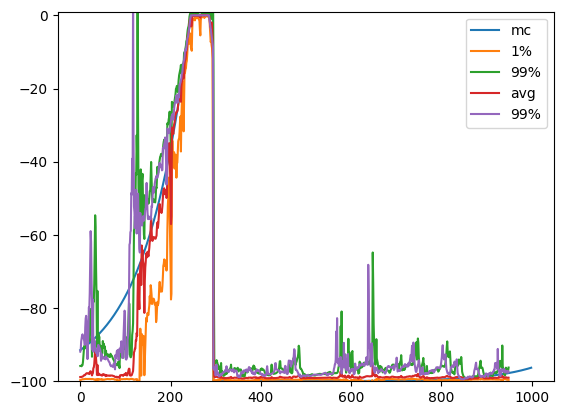

In [57]:
import matplotlib.pyplot as plt

for i in range(0, 15):
    obs_sample = train_dataset['observations'][i*1000:(i)*1000 + 950]
    next_obs_sample = train_dataset['observations'][i*1000 + 10:i*1000 + 960]
    rew_sample = train_dataset['rewards'][i*1000:(i)*1000 + 950]
    mask = train_dataset['masks'][i*1000:(i)*1000 + 950]
    current_zs = agent.network.select('critic')(obs_sample)
    next_zs = agent.network.select('critic')(next_obs_sample)
    n_step_returns = create_discounted_n_step_windows(train_dataset['rewards'][i*1000:(i)*1000 + 960], n_step=10, gamma=0.99)
    advantage = jnp.expand_dims(n_step_returns, axis=-1) + jnp.expand_dims((0.99 ** 10) * mask, axis=-1) * next_zs
    # advantage = jnp.expand_dims((0.99 ** 10) * mask, axis=-1) * next_zs
    # print(advantage.shape)
    np_zs = np.array(current_zs)

    # plt.plot(rew_sample*100)
    
    # plt.show()
    plt.plot(mc_return[i*1000:(i+1)*1000], label='mc')
    plt.ylim([-100, 1])
    # plt.plot(np_zs[:, 0])
    plt.plot(np_zs[:, 1], label='1%')
    # plt.plot(np_zs[:, -1])
    plt.plot(np_zs[:, -2], label='99%')
    plt.plot(np_zs.mean(axis=-1), label='avg')

    # plt.plot(advantage[:, 1], label='1%')
    # plt.plot(np_zs[:, -1])
    plt.plot(advantage[:, -2], label='99%')
    # plt.plot(advantage.mean(axis=-1), label='adv avg')
    plt.legend()
    # plt.plot(np_zs[:, 25])
    plt.show()